In [1]:
print("""Tutorial on how to create a denoising autoencoder with Tensorflow.
forked from Parag K. Mital, Jan. 2016""")

Tutorial on how to create a denoising autoencoder with Tensorflow.
forked from Parag K. Mital, Jan. 2016


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import math
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.examples.tutorials.mnist.input_data as input_data

In [3]:
def corrupt(x):
    """Take an input tensor and add uniform masking.
    Parameters
    ----------
    x : Tensor/Placeholder
        Input to corrupt.
    Returns
    -------
    x_corrupted : Tensor
        50 pct of values corrupted.
    """
    return tf.multiply(x, tf.cast(tf.random_uniform(tf.shape(x), 0, 2, tf.int32), tf.float32))

In [4]:
def autoencoder(dimensions=[784, 512, 256, 64]):
    """Build a deep denoising autoencoder w/ tied weights.

    Parameters
    ----------
    dimensions : list, optional
        The number of neurons for each layer of the autoencoder.

    Returns
    -------
    x : Tensor
        Input placeholder to the network
    z : Tensor
        Inner-most latent representation
    y : Tensor
        Output reconstruction of the input
    loss : Tensor
        Overall loss to use for training
    """
    # input to the network
    x = tf.placeholder(tf.float32, [None, dimensions[0]], name='x')

    # Probability that we will corrupt input.
    # This is the essence of the denoising autoencoder, and is pretty basic. 
    # We'll feed forward a noisy input, allowing our network to generalize better, 
    # possibly, to occlusions of what we're really interested in. 
    # But to measure accuracy, we'll still enforce a training signal 
    # which measures the original image's reconstruction loss.
    #
    # We'll change this to 1 during training
    # but when we're ready for testing/production ready environments,
    # we'll put it back to 0.
    corrupt_prob = tf.placeholder(tf.float32, [1])
    current_input = corrupt(x) * corrupt_prob + x * (1 - corrupt_prob)

    # Build the encoder
    encoder = []
    for layer_i, n_output in enumerate(dimensions[1:]):
        n_input = int(current_input.get_shape()[1]) # 784, 512, 256
        init_max = 1.0 / math.sqrt(n_input)
        W = tf.Variable(tf.random_uniform([n_input, n_output], -init_max, init_max)) # (784, 512) (512, 256) (256, 64)
        b = tf.Variable(tf.zeros([n_output]))
        encoder.append(W) # (784, 512) (512, 256) (256, 64)
        output = tf.nn.tanh(tf.matmul(current_input, W) + b) # (n, 512) (n, 256) (n, 64)
        current_input = output
        
    # latent representation
    z = current_input # (n, 64)
    encoder.reverse() # (256, 64) (512, 256) (784, 512)
    
    # Build the decoder using the same weights
    for layer_i, n_output in enumerate(dimensions[:-1][::-1]):
        W = tf.transpose(encoder[layer_i]) # (64, 256) (256, 512) (512, 784) 
        b = tf.Variable(tf.zeros([n_output]))
        output = tf.nn.tanh(tf.matmul(current_input, W) + b) # (n, 256) (n, 512) (n, 784)
        current_input = output
        
    # now have the reconstruction through the network
    y = current_input # (n, 784)
    
    # loss function measures pixel-wise difference
    loss = tf.sqrt(tf.reduce_mean(tf.square(y - x)))
    return {'x': x, 'z': z, 'y': y, 'corrupt_prob': corrupt_prob, 'loss': loss}

In [5]:
# %% Basic test
def test_mnist():
    """Test the autoencoder using MNIST."""
    # load MNIST as before
    mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
    mean_img = np.mean(mnist.train.images, axis=0)
    ae = autoencoder(dimensions=[784, 256, 64])

    learning_rate = 0.001
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(ae['loss'])

    # We create a session to use the graph
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    # Fit all training data
    batch_size = 50
    n_epochs = 5
    for epoch_i in range(n_epochs):
        for batch_i in range(mnist.train.num_examples // batch_size):
            batch_xs, _ = mnist.train.next_batch(batch_size)
            train = np.array([img - mean_img for img in batch_xs])
            sess.run(optimizer, feed_dict={ae['x']: train, ae['corrupt_prob']: [1.0]})
        print(epoch_i, sess.run(ae['loss'], feed_dict={ae['x']: train, ae['corrupt_prob']: [1.0]}))

    # Plot example reconstructions
    n_examples = 15
    test_xs, _ = mnist.test.next_batch(n_examples)
    test_xs_norm = np.array([img - mean_img for img in test_xs])
    recon = sess.run(ae['y'], feed_dict={ae['x']: test_xs_norm, ae['corrupt_prob']: [0.0]})
    fig, axs = plt.subplots(2, n_examples, figsize=(10, 2))
    for example_i in range(n_examples):
        axs[0][example_i].imshow(np.reshape(test_xs[example_i, :], (28, 28)))
        axs[1][example_i].imshow(np.reshape([recon[example_i, :] + mean_img], (28, 28)))
    plt.draw()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
0 0.141857
1 0.131946
2 0.130514
3 0.129786
4 0.12406


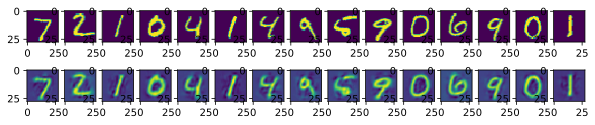

In [6]:
test_mnist()